In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from scripts.lmfit_model import division_model, sum_model

In [3]:
def qh_plot(qh_df: pd.DataFrame):
    x = qh_df["q_cms"].to_numpy()
    y = qh_df["lvl_sm"].to_numpy()
    y_qh = qh_df["lvl_qh"].to_numpy()

    fig, ax = plt.subplots()
    ax.scatter(x, y, s=10, label="Кривая Q(h) по АИС")
    ax.scatter(x, y_qh, s=15, label="Уровни по кривой Q(h)", color="green")
    ax.set_xlabel("Расход, куб. м/с")
    ax.set_ylabel("Уровень, см")
    ax.legend()
    plt.close()
    return ax.get_figure()


In [4]:
initial_gauges = gpd.read_file("data/geometry/russia_gauges_full.gpkg")
initial_gauges = initial_gauges.set_index("gauge_id")

### Visualize Q(h) from lmfit model

In [8]:
qh_lmfit_images = Path("data/images/qh_lmfit_full")
qh_lmfit_images.mkdir(exist_ok=True, parents=True)
param_path = Path("data/params/qh_full")
result_folder = Path("data/res/qh_full/")
result_folder.mkdir(exist_ok=True, parents=True)

param_gauges = list(i.stem.split("_") for i in Path(f"{param_path}").glob("*.json"))
q_gauges = list(i.stem for i in Path("data/HydroReady/").glob("*.pkl"))
param_gauges = [i for i in param_gauges if i[0] in q_gauges]

for desc in tqdm(param_gauges):
    result = None
    gauge_id, model_type = desc
    # if Path(f"{result_folder}/{gauge_id}.pkl").is_file():
    #     continue
    hydro_file = pd.read_csv(f"data/HydroFiles/{gauge_id}.csv", parse_dates=True, index_col="date")
    hydro_file[hydro_file <= 0] = np.nan
    data_file = pd.read_pickle(f"data/HydroReady/{gauge_id}.pkl")
    data_file = data_file.dropna()
    y = data_file["lvl_sm"].to_numpy()
    x = data_file["q_cms"].to_numpy()
    if model_type == "sum":
        try:
            params = sum_model.make_params(power=1, c=1, slope=1, b=1)
            result = sum_model.fit(y, params, x=x)
        except ValueError:
            params = sum_model.make_params(power=0, c=1, slope=1, b=1)
            result = sum_model.fit(y, params, x=x)
    elif model_type == "div":
        try:
            params = division_model.make_params(power=1, c=1, slope=1, b=1)
            result = division_model.fit(y, params, x=x)
        except ValueError:
            params = division_model.make_params(power=0, c=1, slope=1, b=1)
            result = division_model.fit(y, params, x=x)
    else:
        print(f"{gauge_id}")
        continue
    with open(f"{param_path}/{gauge_id}_{model_type}.json", "r") as f:
        params = result.params.load(f)
    hydro_file["lvl_qh"] = [result.eval(x=i, params=params) for i in hydro_file["q_cms"].to_numpy()]
    hydro_file.to_pickle(f"{result_folder}/{gauge_id}.pkl")


  0%|          | 0/1724 [00:00<?, ?it/s]

In [9]:
pkl_files = list(Path(f"{result_folder}").glob("*.pkl"))
for file in tqdm(pkl_files):
    hydro_file = pd.read_pickle(file)
    img = qh_plot(hydro_file)
    img.savefig(f"{qh_lmfit_images}/{file.stem}.png")


  0%|          | 0/1724 [00:00<?, ?it/s]

In [18]:
qh_lmfit_images = Path("data/images/qh_lmfit_open")
qh_lmfit_images.mkdir(exist_ok=True, parents=True)
param_path = Path("data/params/qh_open")
result_folder = Path("data/res/qh_open/")
result_folder.mkdir(exist_ok=True, parents=True)

param_gauges = list(i.stem.split("_") for i in Path(f"{param_path}").glob("*.json"))
q_gauges = list(i.stem for i in Path("data/HydroReady/").glob("*.pkl"))
param_gauges = [i for i in param_gauges if i[0] in q_gauges]

for desc in tqdm(param_gauges):
    result = None
    gauge_id, model_type = desc
    if Path(f"{result_folder}/{gauge_id}.pkl").is_file():
        continue
    hydro_file = pd.read_csv(f"data/HydroFiles/{gauge_id}.csv", parse_dates=True, index_col="date")
    hydro_file[hydro_file <= 0] = np.nan
    data_file = pd.read_pickle(f"data/HydroReady/{gauge_id}.pkl")
    data_file = data_file.dropna()
    y = data_file["lvl_sm"].to_numpy()
    x = data_file["q_cms"].to_numpy()
    if model_type == "sum":
        try:
            params = sum_model.make_params(power=1, c=1, slope=1, b=1)
            result = sum_model.fit(y, params, x=x)
        except ValueError:
            params = sum_model.make_params(power=0, c=1, slope=1, b=1)
            result = sum_model.fit(y, params, x=x)
    elif model_type == "div":
        try:
            params = division_model.make_params(power=1, c=1, slope=1, b=1)
            result = division_model.fit(y, params, x=x)
        except ValueError:
            params = division_model.make_params(power=0, c=1, slope=0, b=1)
            result = division_model.fit(y, params, x=x)
    else:
        print(f"{gauge_id}")
        continue
    with open(f"{param_path}/{gauge_id}_{model_type}.json", "r") as f:
        params = result.params.load(f)
    hydro_file["lvl_qh"] = [result.eval(x=i, params=params) for i in hydro_file["q_cms"].to_numpy()]
    hydro_file.to_pickle(f"{result_folder}/{gauge_id}.pkl")

pkl_files = list(Path(f"{result_folder}").glob("*.pkl"))
for file in tqdm(pkl_files):
    hydro_file = pd.read_pickle(file)
    img = qh_plot(hydro_file)
    img.savefig(f"{qh_lmfit_images}/{file.stem}.png")


  0%|          | 0/1698 [00:00<?, ?it/s]

  0%|          | 0/1698 [00:00<?, ?it/s]

### Select for next calculations only gauges with good enough Q(h)

In [20]:
from scripts.metrics import rmse

In [26]:
pkl_files = list(Path("data/res/qh_open").glob("*.pkl"))

reasonable_gauges = list()
for file in tqdm(pkl_files):
    hydro_file = pd.read_pickle(file)
    if rmse(y_true=hydro_file["lvl_sm"], y_pred=hydro_file["lvl_qh"]) < 25.:
        reasonable_gauges.append(file.stem)
        img = qh_plot(hydro_file)
        img.savefig(f"data/res/qh_open_images/{file.stem}.png")
    else:
        continue


  0%|          | 0/1698 [00:00<?, ?it/s]

In [29]:
gauges_for_work = initial_gauges.loc[reasonable_gauges, :]
gauges_for_work.to_file("data/geometry/qh_gauges.gpkg")

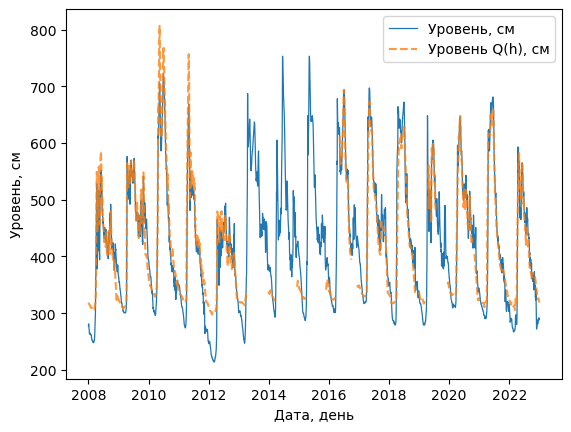

In [101]:
import matplotlib.pyplot as plt
import numpy as np

def plot_q_h(df: pd.DataFrame):

    # Create the figure and axes objects
    fig, ax = plt.subplots()
    # Data for the plot
    x = test_file.index
    y1 = test_file['lvl_sm']
    y2 = test_file['lvl_qh']

    # Create the plot
    ax.plot(x, y1, label="Уровень, см", linestyle="-", linewidth=0.9)  # Full line (default)
    ax.plot(x, y2, label="Уровень Q(h), см", linestyle="--", alpha=0.8)  # Dashed line

    # Adding labels and title
    ax.set_xlabel("Дата, день")
    ax.set_ylabel("Уровень, см")

    # Show the legend
    ax.legend()

    return ax.get_figure()

# Display the plot
plt.show()


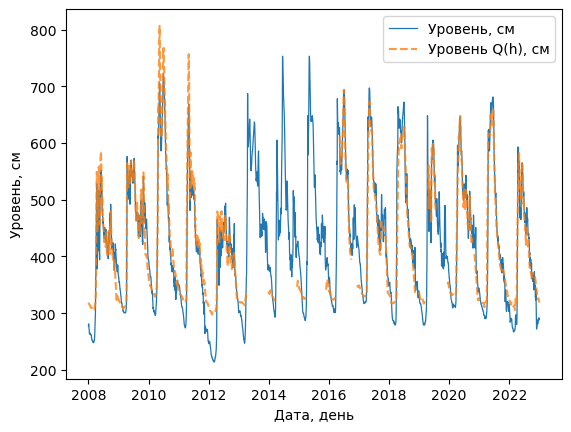

In [103]:
ax.get_figure()

In [47]:
qh_lmfit_images = Path("data/images/qh_lmfit")
qh_lmfit_images.mkdir(exist_ok=True, parents=True)
param_path = Path("data/params/qh_open")
result_folder = Path("data/res/qh_open/")
result_folder.mkdir(exist_ok=True, parents=True)

param_gauges = list(i.stem.split("_") for i in Path(f"{param_path}").glob("*.json"))
q_gauges = list(i.stem for i in Path("data/HydroReady/").glob("*.pkl"))
param_gauges = [i for i in param_gauges if i[0] in q_gauges]

for desc in tqdm(param_gauges):
    result = None
    gauge_id, model_type = desc
    hydro_file = pd.read_csv(f"data/HydroFiles/{gauge_id}.csv", parse_dates=True, index_col="date")
    hydro_file[hydro_file <= 0] = np.nan
    data_file = pd.read_pickle(f"data/HydroReady/{gauge_id}.pkl")
    data_file = data_file.dropna()
    y = data_file["lvl_sm"].to_numpy()
    x = data_file["q_cms"].to_numpy()
    if model_type == "sum":
        params = sum_model.make_params(power=1, c=1, slope=1, b=1)
        result = sum_model.fit(y, params, x=x)
    elif model_type == "div":
        try:
            params = division_model.make_params(power=1, c=1, slope=1, b=1)
            result = division_model.fit(y, params, x=x)
        except ValueError:
            params = division_model.make_params(power=0, c=1, slope=1, b=1)
            result = division_model.fit(y, params, x=x)
    else:
        print(f"{gauge_id}")
        continue
    with open(f"{param_path}/{gauge_id}_{model_type}.json", "r") as f:
        params = result.params.load(f)
    hydro_file["lvl_qh"] = [result.eval(x=i, params=params) for i in hydro_file["q_cms"].to_numpy()]
    hydro_file.to_pickle(f"{result_folder}/{gauge_id}.pkl")
